PARTE 0

Como paso previo al inicio del analisis se instalo la libreria "wfdb". Esta librería permite leer y procesar los datos de señales fisiológicas (como el ECG) que están almacenados en el formato estandarizado de la base de datos PhysioNet.

Este formato típicamente consta de tres archivos por cada registro: Un archivo "header" (.hea) que contiene metadatos importantes como la frecuencia de muestreo (fs) y el factor de ganancia. Todos datos fundamentales para poder procesar el ECG correctamente

Un archivo de datos (.dat) que contiene todos los datos que permiten reconstruir efectivamente el ECG.

Un archivo de anotaciones (.atr) el cual en este trabajo no se utilizo.

In [2]:
!pip install wfdb matplotlib numpy PyWavelets scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 84.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


PARTE 1

En esta primera parte se busca importar todas las bibliotecas necesarias para poder generar la señal ECG que luego se procesara. Como parte del analisis no solo se mostrara la señal obtenida si no tambien la frecuencia de muestreo y la duración del registro.


--- Cargando registro: x0010 desde ./x0010 ---
Frecuencia de muestreo (Hz): 977
Número de señales: 19
Nombres de las señales: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'ABL12', 'RVA12', 'CS12', 'CS34', 'CS56', 'CS78', 'CS90']
Duración del registro (segundos): 317.56
Mostrando el rango de tiempo de 0 a 10 segundos.


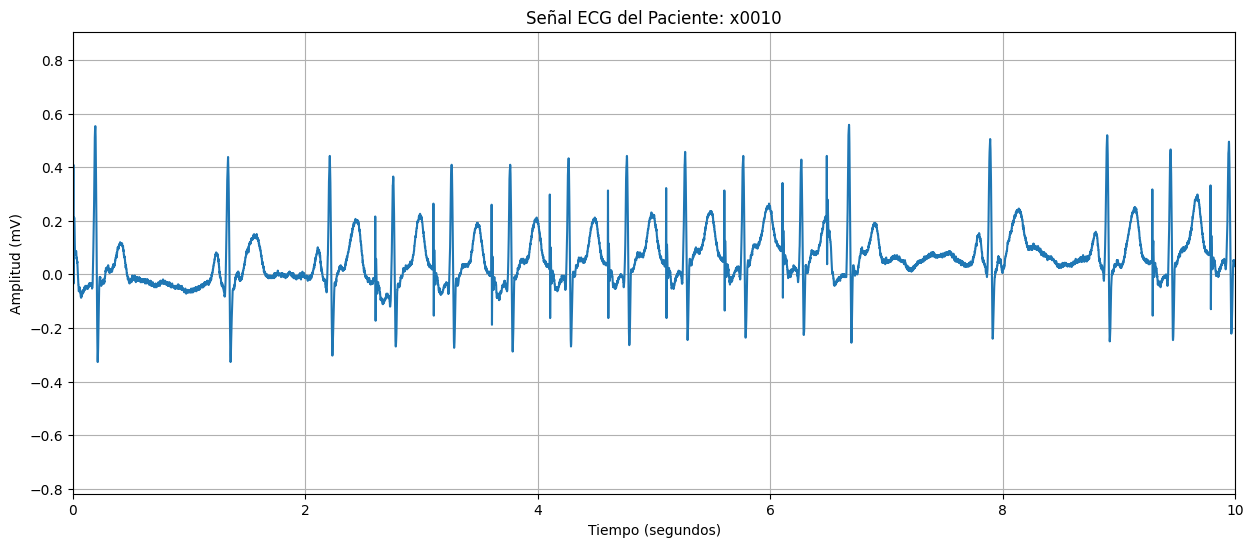

In [48]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import os

def load_and_plot_ecg(record_name, base_path='./', start_time_sec=None, end_time_sec=None):

    full_path = os.path.join(base_path, record_name)
    print(f"\n--- Cargando registro: {record_name} desde {full_path} ---")

    try:
        record = wfdb.rdrecord(full_path)

        # Muestra información básica del registro.
        print(f"Frecuencia de muestreo (Hz): {record.fs}")
        print(f"Número de señales: {record.n_sig}")
        print(f"Nombres de las señales: {record.sig_name}")

        # Calcular duración de la señal.
        duration_seconds = None
        if hasattr(record, 'siglen') and record.siglen is not None:
            duration_seconds = record.siglen / record.fs
        elif record.p_signal is not None:
            duration_seconds = len(record.p_signal) / record.fs

        if duration_seconds is not None:
            print(f"Duración del registro (segundos): {duration_seconds:.2f}")
        else:
            print("No se pudo determinar la duración de la señal.")

        # Extrae los datos de la señal ECG.
        if record.p_signal is not None and record.p_signal.shape[1] > 0:
            ecg_signal = record.p_signal[:, 0]
            fs = record.fs

            # Genera el vector de tiempo
            time = np.arange(len(ecg_signal)) / record.fs

            # Grafica la señal ECG
            plt.figure(figsize=(15, 6))
            plt.plot(time, ecg_signal)
            plt.title(f'Señal ECG del Paciente: {record_name}')
            plt.xlabel('Tiempo (segundos)')
            plt.ylabel('Amplitud (mV)')
            plt.grid(True)

            # --- Ajustar el período de tiempo ---
            if start_time_sec is not None or end_time_sec is not None:
                plt.xlim(start_time_sec, end_time_sec)
                print(f"Mostrando el rango de tiempo de {start_time_sec if start_time_sec is not None else 'Inicio'} a {end_time_sec if end_time_sec is not None else 'Fin'} segundos.")

            plt.show()
            return ecg_signal, fs # Devolver la señal y fs

        else:
            print(f"Error: La señal ECG para {record_name} no pudo ser extraída o está vacía.")
            return None, None # Devolver None, None en caso de error

    except Exception as e:
        print(f"Error al procesar el registro {record_name}: {e}")

patient_id = 'x0010'
base_directory = './' # Ajusta esto según tu configuración en Colab
start_time = 0
end_time = 10 # Por ejemplo, para mostrar los primeros 10 segundos. Una vez conocido el tiempo se puede poner el completo.

ecg_signal, fs= load_and_plot_ecg(patient_id, base_path=base_directory,
                          start_time_sec=start_time, end_time_sec=end_time)

En este tramo del codigo busco el espectro de frecuencias y el espectograma para detectar frecuencias no deseadas y saber si es necesario filtrar el codigo.


--- Calculando y graficando el Espectro de Frecuencias (FFT) ---


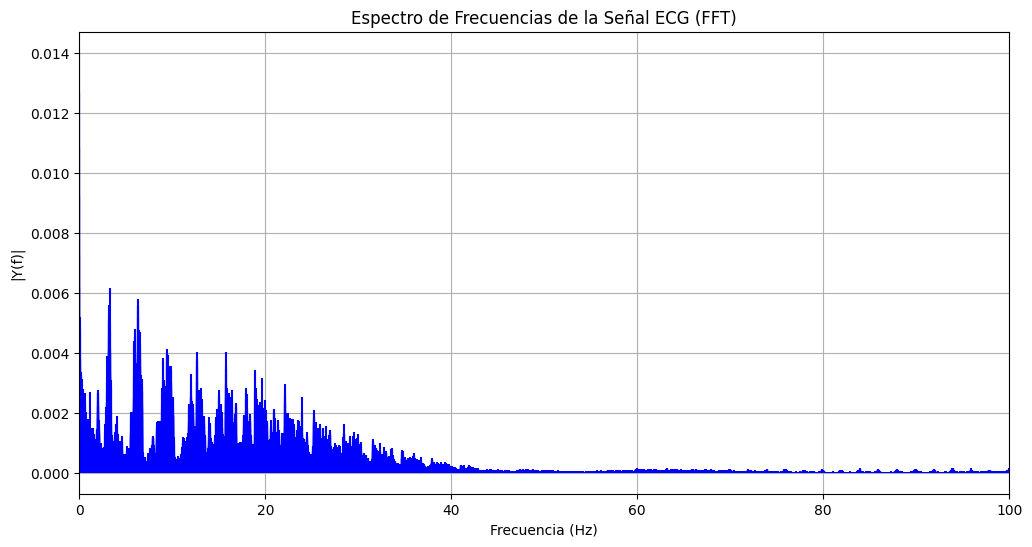

--- Espectro de Frecuencias (FFT) completado ---


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq

print("\n--- Calculando y graficando el Espectro de Frecuencias (FFT) ---")

dt = 1 / fs

# 1. Calcular la FFT
# La FFT de la señal. Dividimos por len(ecg_signal) para normalizar la amplitud.
Y = fft(ecg_signal) / len(ecg_signal)

# 2. Generar el vector de frecuencias correspondiente
# fftfreq genera las frecuencias para los puntos de la FFT.
frq = fftfreq(len(ecg_signal), dt)

# 3. Graficar el espectro de magnitud
plt.figure(figsize=(12, 6))

plt.vlines(frq, 0, np.abs(Y), colors='blue')

plt.title('Espectro de Frecuencias de la Señal ECG (FFT)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('|Y(f)|')

plt.xlim(0, 100)

plt.grid(True)
plt.show()

print("--- Espectro de Frecuencias (FFT) completado ---")

En este caso en el espectograma no se detectan frecuencias indeseadas por lo que la señal parece estar sin ruido, al menos de los mas frecuentes. Entre estos se encuentran:

Ruido de la linea electrica alrededor de los 50Hz.

Desplazamiento de la linea base por debajo de los 0.5 Hz.

Ruido de alta frecuencia, por ejemplo muscular, por encima de los 50 Hz.

Es por este motivo que no se aplicara ningún filtro y se procede a detectar los picos y analizar el estado del paciente.


--- Iniciando Detección de Picos R-R ---


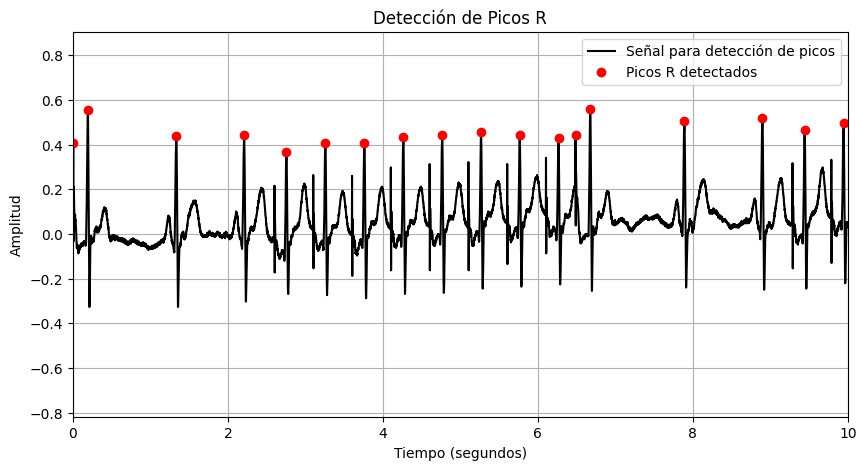

Se encontraron 900 picos R en el segmento analizado.
Intervalos R-R (en segundos): [0.18833163 1.14124872 0.87615148 0.54554759 0.50255885 0.5035824
 0.50255885 0.50153531 0.50051177 0.50051177 0.49948823 0.21903787
 0.19140225 1.21392016 1.00614125 0.54554759 0.50255885 0.50153531
 1.         0.50255885 0.50255885 0.5035824  0.20470829 0.2221085
 1.10030706 1.56704197 0.51995906 0.5035824  0.50153531 0.50153531
 0.49948823 0.21801433 0.28249744 0.41248721 0.28556807 0.19344933
 0.22006141 0.93551689 0.24667349 0.71647902 0.54452405 0.50255885
 0.50255885 0.50153531 0.50255885 0.50255885 0.33469806 0.16888434
 0.50255885 0.1801433  0.22927329 1.05220061 0.9825998  0.54554759
 0.50562948 0.5035824  0.50153531 0.50153531 0.98976459 0.68474923
 0.22927329 1.17195496 0.99897646 0.54657114 0.50153531 0.50460594
 0.50153531 0.5035824  0.5035824  0.50051177 0.50153531 0.39918117
 1.05015353 1.00716479 0.54554759 0.50460594 0.50255885 0.50153531
 0.99181167 1.00716479 0.40327533 1.06653019 0.8

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

print("\n--- Iniciando Detección de Picos R-R ---")

# Genero el vector de tiempo.
time = np.arange(len(ecg_signal)) / fs

signal_for_peaks = ecg_signal

peaks, _ = find_peaks(signal_for_peaks, height=np.max(signal_for_peaks)*0.4, distance=fs/6)

# Graficar la señal y resaltar los picos encontrados
plt.figure(figsize=(10, 5))
plt.plot(time, signal_for_peaks, label='Señal para detección de picos', color = 'k')
plt.plot(time[peaks], signal_for_peaks[peaks], 'ro', label='Picos R detectados')
plt.title('Detección de Picos R')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Amplitud')

plt.legend()
plt.grid(True)

plt.xlim(start_time, end_time)

plt.show()


#Incluyo los cálculos de RR y BPM para que sean parte de este bloque funcional:
print(f"Se encontraron {len(peaks)} picos R en el segmento analizado.")

if len(peaks) > 1:
    rr_intervals_samples = np.diff(peaks)
    rr_intervals_seconds = rr_intervals_samples / fs

    print(f"Intervalos R-R (en segundos): {rr_intervals_seconds}")

    mean_rr_seconds = np.mean(rr_intervals_seconds)
    heart_rate_bpm = 60 / mean_rr_seconds
    print(f"Frecuencia Cardíaca Promedio: {heart_rate_bpm:.2f} BPM")

    if heart_rate_bpm > 100:
        print("¡Indicador de Taquicardia!")
    elif heart_rate_bpm < 60:
        print("Indicador de Bradicardia.")
    else:
        print("Frecuencia Cardíaca Normal.")
else:
    print("No se encontraron suficientes picos R para calcular los intervalos R-R o la frecuencia cardíaca.")

print("--- Detección de picos R-R completada ---")

PARTE 2

En esta segunda parte se le aplicara a la señal la ondícula de Daubechies ya que permite captar detalles que otras ondículas no captan. Esto, sumado al hecho de que incluso si una señal no es bien representada por un miembro de la familia Daubechies, todavía puede ser representada eficientemente por otro, explica porque se analizará la señal con esta familia de ondículas.


--- Graficando coeficientes para 'db10' a nivel 5 ---


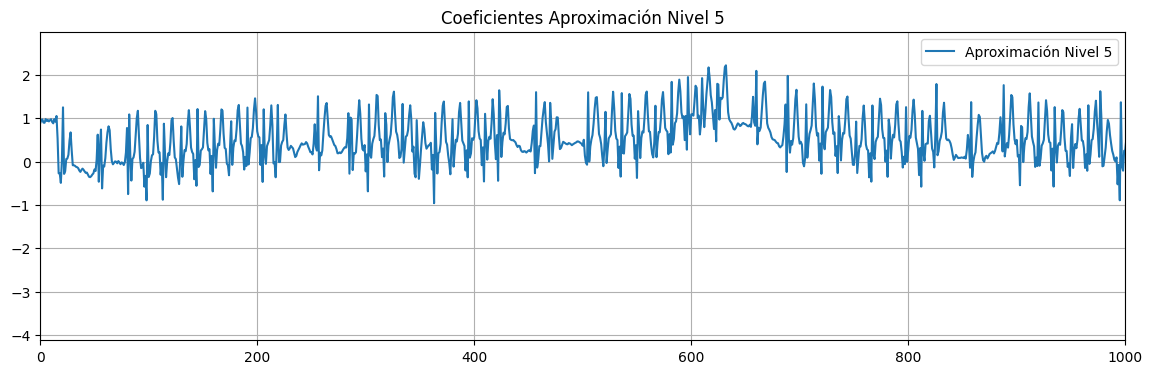

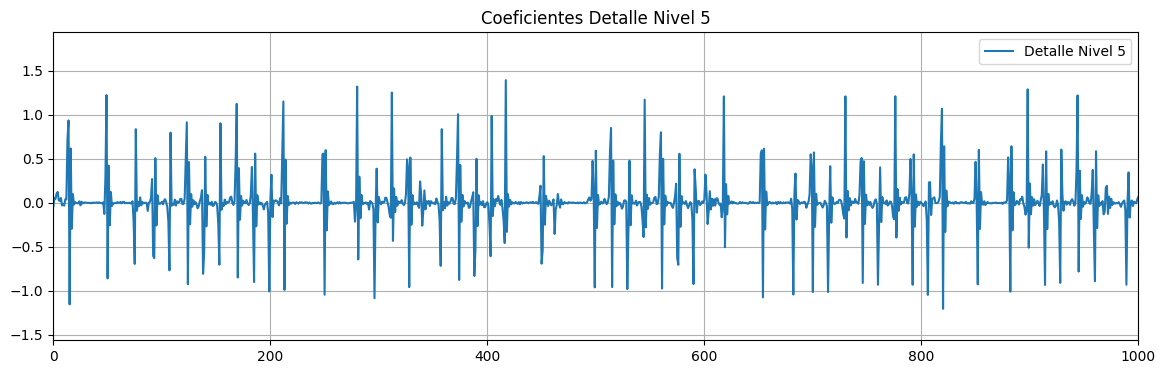

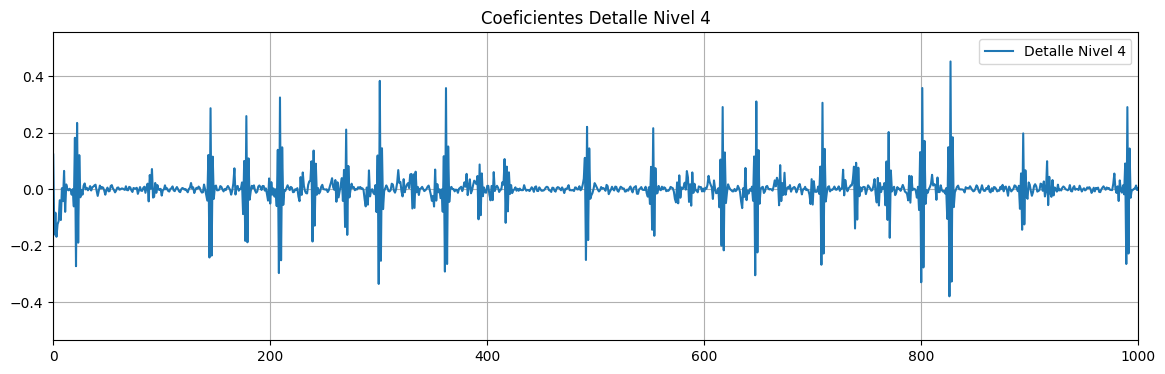

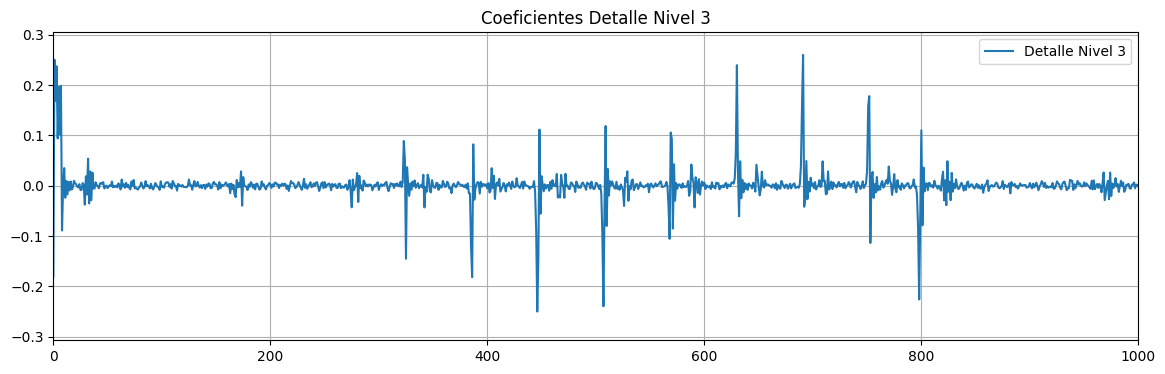

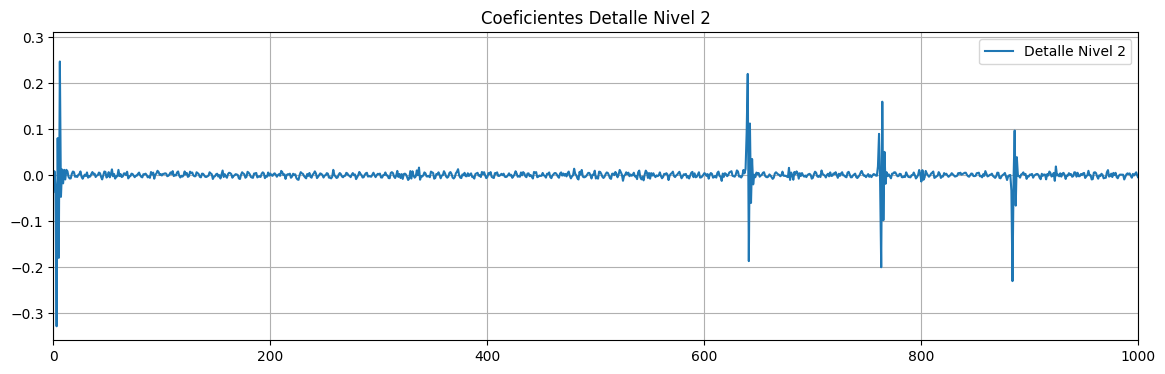

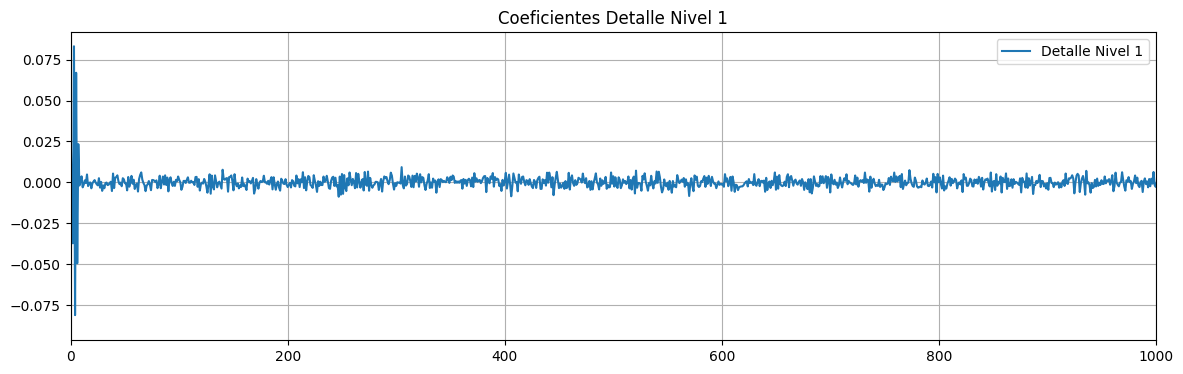

--- Graficado de coeficientes completado ---


In [54]:
import pywt
import matplotlib.pyplot as plt
import numpy as np

# La 'w' es la ondita (Daubechies 10)
wav = pywt.Wavelet('db10')

# Calcula el número máximo de niveles de descomposición para la señal ECG
cant_niveles = 5

# Hace la descomposición wavelet
coef = pywt.wavedec(ecg_signal, wavelet=wav, level=cant_niveles)

print(f"\n--- Graficando coeficientes para '{wav.name}' a nivel {cant_niveles} ---")
for i in range(0, cant_niveles + 1):
    fig = plt.figure(figsize=(14, 4))

    if i == 0:
        label = f'Aproximación Nivel {cant_niveles}'
    else:
        label = f'Detalle Nivel {cant_niveles - i + 1}'

    plt.plot(coef[i], label=label)
    plt.title(f'Coeficientes {label}')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.xlim(0, 1000)
    plt.show()

print("--- Graficado de coeficientes completado ---")

Los coeficientes de detalle aportan distinta información dependiendo del nivel que se analice:

Nivel 1: Este nivel generalmente contiene ruido de alta frecuencia, como artefactos eléctricos o interferencias. Por lo tanto, como se vio previamente al buscar el espectro de frecuencia, este nivel no aporta información útil.

Nivel 2: No aporta información util.

Niveles 3 y 4: Permiten vizualizar el complejo QRS con claridad.

Nivel 5: Este nivel, además del complejo QRS, permite visualizar las onda 'P' y 'T'

Por último, el coeficiente de aproximación permite ver el contorno global de la señal ECG, sin picos definidos pero con oscilaciones que marcan cierta periodicidad.

Parte 3

El gráfico del plano Tiempo-Escala es una herramienta sumamente util para el analisis de señales ECG ya que permite analizar como varia la frecuencia de la señal en función del tiempo. Permitiendo esto ver con que frecuencia se repiten ciertos eventos.


--- Generando Transformada Wavelet Continua (CWT) y Plano Tiempo-Escala ---


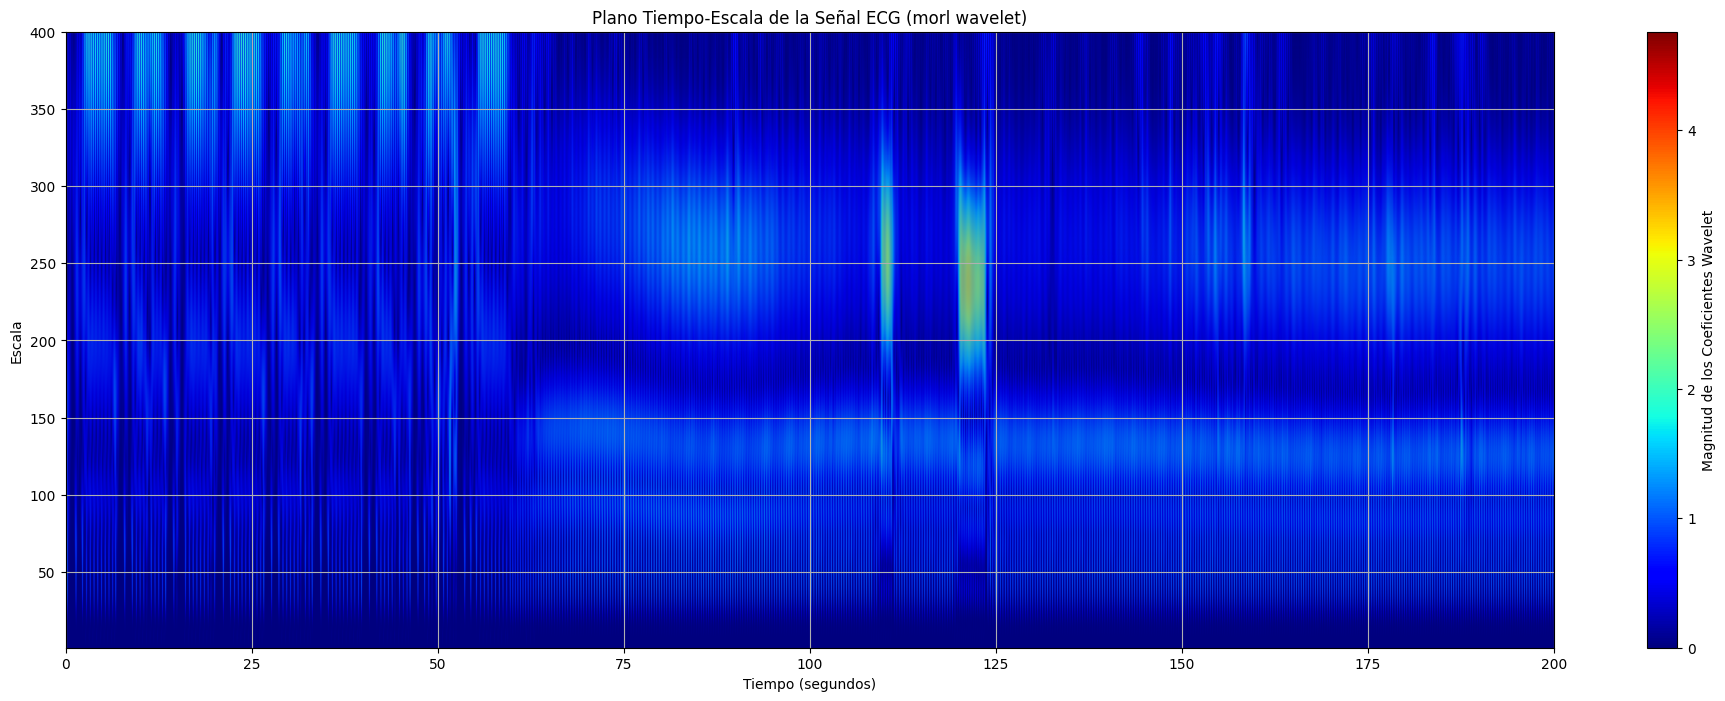

--- Plano Tiempo-Escala completado ---


In [56]:
import pywt
import matplotlib.pyplot as plt
import numpy as np

print("\n--- Generando Transformada Wavelet Continua (CWT) y Plano Tiempo-Escala ---")

# 1. Elijo una Mother Wavelet para CWT (Morlet es muy común para análisis)
wavelet_cwt = 'morl'

# 2. Defino un rango de escalas
# Escalas bajas para detalles rápidos (alta frecuencia)
# Escalas altas para cambios lentos (baja frecuencia)
min_scale = 1
max_scale = 400
scales = np.arange(min_scale, max_scale + 1)

# 3. Realizo la Transformada Wavelet Continua
coefficients, frequencies = pywt.cwt(ecg_signal, scales, wavelet_cwt, sampling_period=1/fs)

# 4. Visualizo el Plano como una imagen (Tiempo-Escala)
plt.figure(figsize=(24, 8))

plt.imshow(np.abs(coefficients),
           extent=[time.min(), time.max(), scales[-1], scales[0]],
           cmap='jet', aspect='auto')

plt.gca().invert_yaxis()

plt.colorbar(label='Magnitud de los Coeficientes Wavelet')
plt.title(f'Plano Tiempo-Escala de la Señal ECG ({wavelet_cwt} wavelet)')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Escala')
plt.grid(True)
plt.xlim(0, 200)
plt.show()

print("--- Plano Tiempo-Escala completado ---")

En este caso se ve que cada ovalo representa al complejo QRS de la señal. Donde los valores de escala pequeños corresponden a cambios rápidos o de alta frecuencia y los valores de escala grandes corresponden a cambios lentos o de baja frecuencia.

En principio, al ser un paciente que previamente se diagnostico con taquicardia, parece tener sentido el resultado obtenido ya que los ovalos se encuentran muy juntos, lo cual representa que el complejo QRS se repite a lo largo del tiempo con una frecuencia baja.